[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/im_segmentation/UNet.ipynb)

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# **Dataset**
download and upload the train.zip and train_masks.zip file from kaggle [link](https://www.kaggle.com/competitions/carvana-image-masking-challenge/data) here

In [ ]:
# upzipping the two files
!unzip train_masks.zip
!unzip train.zip

In [5]:
# loading dataset
class CarvanaDataset(Dataset):
    def __init__(self, test=False):
        self.images = sorted(["train/"+i for i in os.listdir("train/")])
        self.masks = sorted(["train_masks/"+i for i in os.listdir("train_masks/")])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)

dataset = CarvanaDataset()

In [6]:
# train and validation split
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=generator)
print(train_dataset, val_dataset)

<torch.utils.data.dataset.Subset object at 0x79e5140f3cd0> <torch.utils.data.dataset.Subset object at 0x79e5140f2800>


In [7]:
# train and validation dataloader
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

# **Modelling**

In [29]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # generative part
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
        )

        # non generative => classification part
        self.out = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)

    def forward(self, x):

        # generative part
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # non generative => classification part
        out = self.out(decoded)

        return out

In [30]:
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv_op = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.conv_op(x)


# class DownSample(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv = DoubleConv(in_channels, out_channels)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#     def forward(self, x):
#         down = self.conv(x)
#         p = self.pool(down)

#         return down, p


# class UpSample(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
#         self.conv = DoubleConv(in_channels, out_channels)

#     def forward(self, x1, x2):
#        x1 = self.up(x1)
#        x = torch.cat([x1, x2], 1)
#        return self.conv(x)


# class UNet(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()
#         self.down_convolution_1 = DownSample(in_channels, 64)
#         #self.down_convolution_2 = DownSample(64, 128)
#         #self.down_convolution_3 = DownSample(128, 256)
#         self.down_convolution_4 = DownSample(64, 512)

#         self.bottle_neck = DoubleConv(512, 1024)

#         self.up_convolution_1 = UpSample(1024, 128)
#         #self.up_convolution_2 = UpSample(512, 256)
#         #self.up_convolution_3 = UpSample(256, 128)
#         self.up_convolution_4 = UpSample(128, 64)

#         self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

#     def forward(self, x):
#        down_1, p1 = self.down_convolution_1(x)
#        down_2, p2 = self.down_convolution_2(p1)
#        down_3, p3 = self.down_convolution_3(p2)
#        down_4, p4 = self.down_convolution_4(p3)

#        b = self.bottle_neck(p4)

#        up_1 = self.up_convolution_1(b, down_4)
#        up_2 = self.up_convolution_2(up_1, down_3)
#        up_3 = self.up_convolution_3(up_2, down_2)
#        up_4 = self.up_convolution_4(up_3, down_1)

#        out = self.out(up_4)
#        return out

In [32]:
# model = UNet(in_channels=3, num_classes=1).to(device)
model = Autoencoder().to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

# **Training**

In [33]:
for epoch in tqdm(range(2)):
    model.train()
    train_running_loss = 0
    for idx, img_mask in enumerate(tqdm(train_dataloader)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)
        optimizer.zero_grad()

        loss = criterion(y_pred, mask)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)

            val_running_loss += loss.item()

        val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print("-"*30)

100%|██████████| 128/128 [03:51<00:00,  1.81s/it]

 50%|█████     | 1/2 [04:57<04:57, 297.27s/it]

------------------------------
Train Loss EPOCH 1: 0.4589
Valid Loss EPOCH 1: 0.3230
------------------------------



100%|██████████| 128/128 [04:04<00:00,  1.91s/it]

100%|██████████| 2/2 [10:02<00:00, 301.20s/it]

------------------------------
Train Loss EPOCH 2: 0.2603
Valid Loss EPOCH 2: 0.2107
------------------------------


In [38]:
torch.save(model.state_dict(), "autoencoder_model.pth")

# **Inference**

In [39]:
# loading model architecture
model = Autoencoder().to(device)

# loading the model with trained weights
model.load_state_dict(torch.load("autoencoder_model.pth", map_location=torch.device(device)))

<ipython-input-39-c604278ce023>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("autoencoder_model.pth", map_location=torch.device(device))

<All keys matched successfully>

In [40]:
# loading testing dataset
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()])

img = transform(Image.open("test_img.jpg")).float().to(device)
img = img.unsqueeze(0)


# performing prediction
pred_mask = model(img)

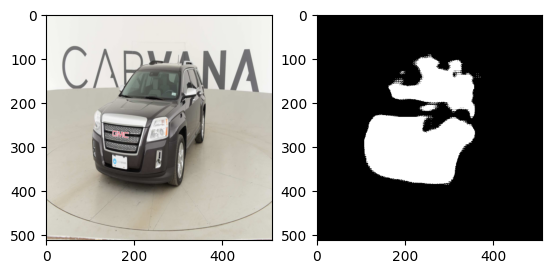

In [41]:
# visualizing
fig = plt.figure()

# showing the original image after doing some post processing
img = img.squeeze(0).cpu().detach()
img = img.permute(1, 2, 0)
fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap="gray")

# showing predicted segmentation mask after doing some post processing
pred_mask = pred_mask.squeeze(0).cpu().detach()
pred_mask = pred_mask.permute(1, 2, 0)
pred_mask[pred_mask < 0]=0
pred_mask[pred_mask > 0]=1
fig.add_subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")

plt.show()